# This is a pipeline to visualize and analyze the results of CellProfiler on Rabies experiments

In [143]:
import os
from utils import data_reader
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt

In [170]:
# Select the path where the data is (the output of CellProfiler)
CPoutput_path = '/mnt/c/Users/herny/Desktop/SWC/Data/Microscopy_Data/Rabies_Tracing/ToS-D1_D2/DataForAnalysis/CellProfilerOutput/'
# Read it in a useful format
RabiesData, cFosData = data_reader.RabiesCP_data_reader(CPoutput_path)

In [161]:
cFosData.head()

,ImageNumber,cFosObjectNumber,Area,Center_X,Center_Y,Compactness,Eccentricity,PercentileInfo,AnimalID,StarterCells,cFosCondition,SliceNumber,BrainSide,InjectionArea
0,1,1,91,92.0,15.0,1.014587,0.475575,cFosPercentile_95_Object,893271,D2,Punish,Slice6,Contra,TODO
1,1,2,227,311.0,27.0,1.067294,0.656519,cFosPercentile_95_Object,893271,D2,Punish,Slice6,Contra,TODO
2,1,3,109,12.0,42.0,1.016388,0.473109,cFosPercentile_95_Object,893271,D2,Punish,Slice6,Contra,TODO
3,1,4,239,291.0,45.0,1.022363,0.559718,cFosPercentile_95_Object,893271,D2,Punish,Slice6,Contra,TODO
4,1,5,57,641.0,54.0,1.663207,0.895343,cFosPercentile_95_Object,893271,D2,Punish,Slice6,Contra,TODO


/home/hmvergara/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


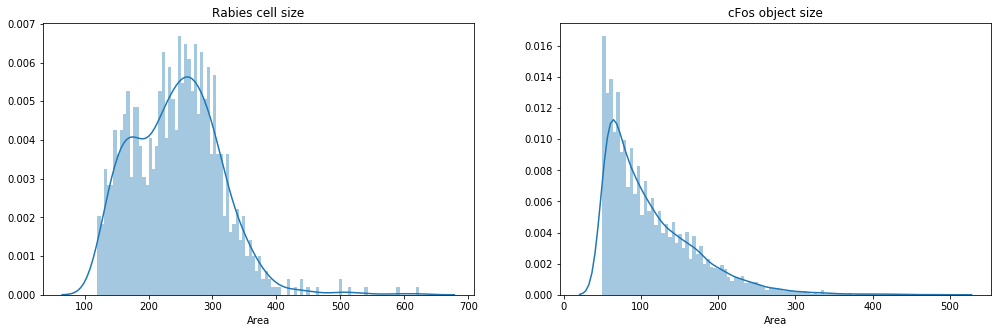

In [173]:
# cell area size
fig, axs = plt.subplots(1,2, figsize=(17,5))
axs = axs.ravel()
sns.distplot(RabiesData.Area, bins=100, ax = axs[0])
axs[0].set_title('Rabies cell size')
sns.distplot(cFosData.Area, bins=100, ax = axs[1])
axs[1].set_title('cFos object size')
plt.show()

In [174]:
# filter by size
RabiesDataSF = RabiesData[RabiesData['Area']>200]

In [182]:
percCol = 'cFosPercentile_98_Object'

TotalRabiesD1 = len(RabiesDataSF[RabiesDataSF['StarterCells']=='D1'])
TotalRabiesD2 = len(RabiesDataSF[RabiesDataSF['StarterCells']=='D2'])
TotalcFosD1 = len(cFosData[np.logical_and(cFosData['StarterCells']=='D1', cFosData['PercentileInfo']==percCol)])
TotalcFosD2 = len(cFosData[np.logical_and(cFosData['StarterCells']=='D2', cFosData['PercentileInfo']==percCol)])
TotalRabiesAndcfosD1 = len(RabiesDataSF[np.logical_and(RabiesDataSF[percCol]!=0, RabiesDataSF['StarterCells']=='D1')])
TotalRabiesAndcfosD2 = len(RabiesDataSF[np.logical_and(RabiesDataSF[percCol]!=0, RabiesDataSF['StarterCells']=='D2')])


print('Total rabies cells:')
print('D1: ',str(TotalRabiesD1))
print('D2: ',str(TotalRabiesD2))


print('\nTotal c-Fos objects:')
print('D1: ',str(TotalcFosD1))
print('D2: ',str(TotalcFosD2))


print('\nOverlap of rabies and c-Fos:')
print('D1: ',str(100 * TotalRabiesAndcfosD1 / (TotalcFosD1 + TotalRabiesD1)))
print('D2: ',str(100 * TotalRabiesAndcfosD2 / (TotalcFosD2 + TotalRabiesD2)))


Total rabies cells:
D1:  166
D2:  532

Total c-Fos objects:
D1:  488
D2:  1772

Overlap of rabies and c-Fos:
D1:  2.599388379204893
D2:  2.907986111111111


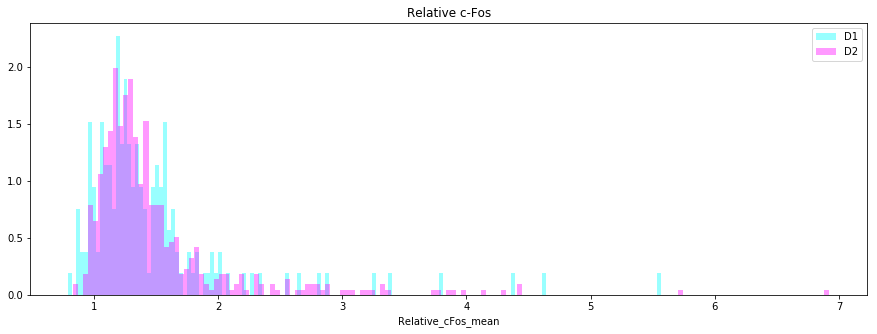

In [141]:
# relative c-fos
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(CPdatacom[CPdatacom['StarterCells']=='D1'].Relative_cFos_mean, bins=150, color = 'cyan', label='D1', kde=False, norm_hist=True)
sns.distplot(CPdatacom[CPdatacom['StarterCells']=='D2'].Relative_cFos_mean, bins=150, color = 'magenta', label='D2', kde=False, norm_hist=True)
plt.legend()
plt.title('Relative c-Fos')
#ax.set_yscale('log')
plt.show()


In [138]:
print('Percentage of cells with more than twice the amount of c-Fos:')
print('D2: ',str(100*len(CPdatacom[np.logical_and(CPdatacom['Relative_cFos_mean']>2, \
                                              CPdatacom['StarterCells']=='D2')])/\
                 len(CPdatacom[CPdatacom['StarterCells']=='D2'])), '%')
print('D1: ',str(100*len(CPdatacom[np.logical_and(CPdatacom['Relative_cFos_mean']>2, \
                                              CPdatacom['StarterCells']=='D1')])/\
                 len(CPdatacom[CPdatacom['StarterCells']=='D1'])), '%')

Percentage of cells with more than twice the amount of c-Fos:
D2:  11.278195488721805 %
D1:  9.63855421686747 %


In [142]:
# plot these cells and see how they look
DStoPlot = CPdatacom[CPdatacom['Relative_cFos_mean']>2]

# plot a random subset of these cells


,ImageNumber,ObjectNumber,AreaShape_Area,AreaShape_Center_X,AreaShape_Center_Y,Intensity_IntegratedIntensity_cfos,Intensity_IntegratedIntensity_rabies,Intensity_MaxIntensity_cfos,Intensity_MaxIntensity_rabies,Intensity_MeanIntensity_cfos,...,Intensity_MedianIntensity_cfos,Intensity_MedianIntensity_rabies,Intensity_StdIntensity_cfos,Intensity_StdIntensity_rabies,AnimalID,StarterCells,cFos_Condition,SliceNumber,BrainSide,Relative_cFos_mean
5,1.0,6.0,201.0,382.0,358.0,12.207843,45.800001,0.235294,0.533333,0.060736,...,0.050980,0.221569,0.044855,0.100897,893271,D2,Punish,Slice10,Contra,2.158871
17,1.0,18.0,309.0,607.0,515.0,24.607844,76.784316,0.749020,0.631373,0.079637,...,0.050980,0.241176,0.106419,0.103374,893271,D2,Punish,Slice10,Contra,2.830733
29,2.0,7.0,291.0,461.0,272.0,21.788236,78.894120,0.313726,0.682353,0.074874,...,0.078431,0.258824,0.057617,0.116856,893271,D2,Punish,Slice10,Ipsi,2.572711
37,2.0,15.0,225.0,734.0,447.0,18.223530,84.321571,0.235294,0.886275,0.080993,...,0.078431,0.341176,0.052214,0.183708,893271,D2,Punish,Slice10,Ipsi,2.782992
61,2.0,39.0,293.0,416.0,732.0,19.819608,88.458826,0.286275,0.745098,0.067644,...,0.050980,0.288235,0.051763,0.134501,893271,D2,Punish,Slice10,Ipsi,2.324285
85,3.0,8.0,265.0,197.0,218.0,45.788237,139.545102,0.549020,0.976471,0.172786,...,0.156863,0.535294,0.123677,0.180793,893271,D2,Punish,Slice1,Ipsi,3.850803
114,3.0,37.0,222.0,284.0,461.0,24.384314,99.847061,0.313726,0.886275,0.109839,...,0.101961,0.431373,0.075635,0.146954,893271,D2,Punish,Slice1,Ipsi,2.447940
123,3.0,46.0,276.0,310.0,537.0,25.419609,120.011768,0.313726,0.929412,0.092100,...,0.078431,0.419608,0.065079,0.157078,893271,D2,Punish,Slice1,Ipsi,2.052594
127,3.0,50.0,273.0,423.0,567.0,46.070589,81.003924,0.521569,0.666667,0.168757,...,0.129412,0.290196,0.141510,0.117316,893271,D2,Punish,Slice1,Ipsi,3.761009
128,3.0,51.0,279.0,519.0,570.0,33.603922,91.168630,0.650980,0.654902,0.120444,...,0.078431,0.325490,0.134392,0.119103,893271,D2,Punish,Slice1,Ipsi,2.684287


In [ ]:
# Check and maybe filter different parameters

# Columns in initial datasets

Index(['ImageNumber', 'ObjectNumber', 'AreaShape_Area', 'AreaShape_Center_X',
       'AreaShape_Center_Y', 'AreaShape_Center_Z', 'AreaShape_Compactness',
       'AreaShape_Eccentricity', 'AreaShape_EulerNumber', 'AreaShape_Extent',
       'AreaShape_FormFactor', 'AreaShape_MajorAxisLength',
       'AreaShape_MaxFeretDiameter', 'AreaShape_MaximumRadius',
       'AreaShape_MeanRadius', 'AreaShape_MedianRadius',
       'AreaShape_MinFeretDiameter', 'AreaShape_MinorAxisLength',
       'AreaShape_Orientation', 'AreaShape_Perimeter', 'AreaShape_Solidity',
       'Intensity_IntegratedIntensityEdge_cfos',
       'Intensity_IntegratedIntensityEdge_rabies',
       'Intensity_IntegratedIntensity_cfos',
       'Intensity_IntegratedIntensity_rabies',
       'Intensity_LowerQuartileIntensity_cfos',
       'Intensity_LowerQuartileIntensity_rabies',
       'Intensity_MADIntensity_cfos', 'Intensity_MADIntensity_rabies',
       'Intensity_MassDisplacement_cfos', 'Intensity_MassDisplacement_rabies',
       'Intensity_MaxIntensityEdge_cfos', 'Intensity_MaxIntensityEdge_rabies',
       'Intensity_MaxIntensity_cfos', 'Intensity_MaxIntensity_rabies',
       'Intensity_MeanIntensityEdge_cfos',
       'Intensity_MeanIntensityEdge_rabies', 'Intensity_MeanIntensity_cfos',
       'Intensity_MeanIntensity_rabies', 'Intensity_MedianIntensity_cfos',
       'Intensity_MedianIntensity_rabies', 'Intensity_MinIntensityEdge_cfos',
       'Intensity_MinIntensityEdge_rabies', 'Intensity_MinIntensity_cfos',
       'Intensity_MinIntensity_rabies', 'Intensity_StdIntensityEdge_cfos',
       'Intensity_StdIntensityEdge_rabies', 'Intensity_StdIntensity_cfos',
       'Intensity_StdIntensity_rabies',
       'Intensity_UpperQuartileIntensity_cfos',
       'Intensity_UpperQuartileIntensity_rabies',
       'Location_CenterMassIntensity_X_cfos',
       'Location_CenterMassIntensity_Y_cfos',
       'Location_CenterMassIntensity_Z_cfos', 'Location_Center_X',
       'Location_Center_Y', 'Location_Center_Z',
       'Location_MaxIntensity_X_cfos', 'Location_MaxIntensity_X_rabies',
       'Location_MaxIntensity_Y_cfos', 'Location_MaxIntensity_Y_rabies',
       'Location_MaxIntensity_Z_cfos', 'Location_MaxIntensity_Z_rabies',
       'Number_Object_Number'],
       
       Index(['Count_CellsAbove', 'FileName_cfos', 'FileName_ilastikOutput',
       'FileName_rabies', 'Group_Index', 'Group_Number', 'ImageNumber',
       'Intensity_LowerQuartileIntensity_cfos',
       'Intensity_LowerQuartileIntensity_rabies',
       'Intensity_MADIntensity_cfos', 'Intensity_MADIntensity_rabies',
       'Intensity_MaxIntensity_cfos', 'Intensity_MaxIntensity_rabies',
       'Intensity_MeanIntensity_cfos', 'Intensity_MeanIntensity_rabies',
       'Intensity_MedianIntensity_cfos', 'Intensity_MedianIntensity_rabies',
       'Intensity_MinIntensity_cfos', 'Intensity_MinIntensity_rabies',
       'Intensity_PercentMaximal_cfos', 'Intensity_PercentMaximal_rabies',
       'Intensity_StdIntensity_cfos', 'Intensity_StdIntensity_rabies',
       'Intensity_TotalArea_cfos', 'Intensity_TotalArea_rabies',
       'Intensity_TotalIntensity_cfos', 'Intensity_TotalIntensity_rabies',
       'Intensity_UpperQuartileIntensity_cfos',
       'Intensity_UpperQuartileIntensity_rabies', 'PathName_cfos',
       'PathName_ilastikOutput', 'PathName_rabies'],
      dtype='object')